#**Sentiment Analysis on hotel Hilton, San Francisco, CA**







##**Methodologies**

**Web Scraping**

The hotel reviews will be scraped from bookings.com by using requests with BeautifulSoup.

**Exploratory Data Analysis (EDA)**

Pie chart, histogram plot to get a better understanding of the reviews and ratings data.

**WordClouds**

Word counts for the positive and negative words.

**Sentiment Analysis**

The sentiment analysis helps to classify the polarity and subjectivity of the overall reviews and determine whether the expressed opinion in the reviews is mostly positive, negative, or neutral.

**Classification and Training Model**

GradientBoostingClassfier

RandomForestClassifer

**LDA Topic Model**

In natural language processing, the latent Dirichlet allocation is a generative statistical model that allows sets of observations to be explained by unobserved groups that explain why some parts of the data are similar. We will use GridSearch to find the best topic model.

#**Objective**

**The objective is to use text analytics and Natural Language Processing (NLP) to extract actionable insights from the reviews and help the hotel improve their guest satisfactions.**

###**Importing the required packages**

In [ ]:
import numpy as np
import pandas as pd

import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
%matplotlib inline
import re

from bs4 import BeautifulSoup as bs
import requests


import string
import nltk
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords,wordnet 
from wordcloud import WordCloud
nltk.download('averaged_perceptron_tagger')
nltk.download('vader_lexicon')
nltk.download('wordnet')

from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV
!pip install pyLDAvis
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()


import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


#**Scraping Data**

Scraping Reviews from Bookings.com

The hotel I have choosen is "Hotel Hilton," San Francisco, CA.

The scraped data includes:

Basic information of the reviewer and reviews:

Rating Score

Reviewer Name

Reviewer's Nationality

Overall Review (contains both positive & negative reviews)

Reviewer Reviewed Times

Review Date

Review Tags like Trip type, such as business trip, leisure trip

Positive reviews

Negative reviews

In [ ]:

def scrape_reviews(hotel_linkname,total_pages):
    '''
    Function to scrape hotel reviews from bookings.com
    INPUTS:
        hotel_linkname - hotel name in the bookings.com weblink
        total_pages - the total number of reviews pages to scrape
    OUTPUTS:
        reviewer_info - a dataframe that includes reviewers' basic information
        pos_reviews -  a dataframe that includes all the positive reviews 
        neg_reviews - a dataframe that includes all the negative reviews
    '''
    #Create empty lists to put in reviewers' information as well as all of the positive & negative reviews 
    info = []
    positive = []
    negative = []
    
    #bookings.com reviews link
    url = 'https://www.booking.com/reviews/us/hotel/'+ hotel_linkname +'.html?page=' +'r_lang=en&customer_type=total&order=featuredreviews'
    page_number = 1

    #Use a while loop to scrape all the pages 
    while page_number <= total_pages:

        page = requests.get(url + str(page_number)) #retrieve data from serve
        soup = bs(page.text, "html.parser") # initiate a beautifulsoup object using the html source and Python’s html.parser
        review_box = soup.find('ul',{'class':'review_list'})

        #ratings
        ratings = [i.text.strip() for i in review_box.find_all('span',{'class':'review-score-badge'})]
        
        #reviewer_info
        reviewer_info = [i.text.strip() for i in review_box.find_all('span',{'itemprop':'name'})]
        reviewer_name = reviewer_info[0::3]
        reviewer_country = reviewer_info[1::3]
        general_review = reviewer_info[2::3]

        # reviewer_review_times
        review_times = [i.text.strip() for i in review_box.find_all('div',{'class':'review_item_user_review_count'})]

        # review_date
        review_date = [i.text.strip().strip('Reviewed: ') for i in review_box.find_all('p',{'class':'review_item_date'})]

        # reviewer_tag
        reviewer_tag = [i.text.strip().replace('\n\n\n','').replace('•',',').lstrip(', ') for i 
                        in review_box.find_all('ul',{'class':'review_item_info_tags'})]

        # positive_review
        positive_review = [i.text.strip('눇').strip() for i in review_box.find_all('p',{'class':'review_pos'})]

        # negative_review
        negative_review = [i.text.strip('눉').strip() for i in review_box.find_all('p',{'class':'review_neg'})]

        # append all reviewers' info into one list
        for i in range(len(reviewer_name)):
            info.append([ratings[i],reviewer_name[i],reviewer_country[i],general_review[i], 
                         review_times[i],review_date[i],reviewer_tag[i]])

        # build positive review list
        for i in range(len(positive_review)):
            positive.append(positive_review[i])

        # build negative review list
        for i in range(len(negative_review)):
            negative.append(negative_review[i])

        # page change
        page_number +=1

    #Reviewer_info df
    reviewer_info = pd.DataFrame(info,
                        columns = ['Rating','Name','Country','Overall_review','Review_times','Review_date','Review_tags'])
    reviewer_info['Rating'] = pd.to_numeric(reviewer_info['Rating'] )
    reviewer_info['Review_times'] = pd.to_numeric(reviewer_info['Review_times'].apply(lambda x:re.findall("\d+", x)[0]))
    reviewer_info['Review_date'] = pd.to_datetime(reviewer_info['Review_date'])
    
    #positive & negative reviews dfs
    pos_reviews = pd.DataFrame(positive,columns = ['positive_reviews'])
    neg_reviews = pd.DataFrame(negative,columns = ['negative_reviews'])
    
    return reviewer_info, pos_reviews, neg_reviews

def show_data(df):
    print("The length of the dataframe is: {}".format(len(df)))
    print("Total NAs: {}".format(reviewer_info.isnull().sum().sum()))
    return df.head()

In [ ]:
reviewer_info, pos_reviews, neg_reviews = scrape_reviews('hilton',total_pages = 42)

###**Reviewers Info**

In [ ]:
show_data(reviewer_info)

The length of the dataframe is: 1050
Total NAs: 0


,Rating,Name,Country,Overall_review,Review_times,Review_date,Review_tags
0,8.0,Eduardo,United States of America,Very Good,37,2021-10-12,"Leisure trip, Couple, Queen Room, Stayed 1 nig..."
1,6.0,Sarah,United States of America,Pleasant,1,2021-09-05,"Leisure trip, Couple, Queen Room, Stayed 1 nig..."
2,8.0,Ryan,United Kingdom,Very Good,4,2020-04-27,"Leisure trip, Solo traveler, Queen Room, Staye..."
3,7.0,Myth,United States of America,Old but great location!,5,2020-04-07,"Couple, Queen Room, Stayed 1 night, Submitted ..."
4,6.0,Mandy,New Zealand,Good value for money and great for one night’s...,22,2020-03-24,"Leisure trip, Couple, Queen Room, Stayed 2 nig..."


###**Positive Reviews**

In [ ]:
show_data(pos_reviews)

The length of the dataframe is: 1008
Total NAs: 0


,positive_reviews
0,Good stop over for the night. Location is great.
1,"Beautiful rooms, great location. Very clean an..."
2,"Location is great, short walk away Chinatown a..."
3,location more than made up for being outdated ...
4,Location


###**Negative Reviews**

In [ ]:
show_data(neg_reviews)

The length of the dataframe is: 798
Total NAs: 0


,negative_reviews
0,"Just for one night, couldn't tell..."
1,"No breakfast because of covid, but we didn’t g..."
2,"Relatively basic, however it is great value fo..."
3,The hotel is very dated with yellow staining o...
4,Very old water pipes which made noises during ...


###**Pickled the Dataset**

Pickled the data and stored in the google drive 

In [ ]:
import pickle
filename = '/content/drive/MyDrive/MachineLearningAssignments/PickledData/reviewer_info.sav'
pickle.dump(reviewer_info, open(filename, 'wb'))

In [ ]:
filename = '/content/drive/MyDrive/MachineLearningAssignments/PickledData/pos_reviews.sav'
pickle.dump(pos_reviews, open(filename, 'wb'))

In [ ]:
filename = '/content/drive/MyDrive/MachineLearningAssignments/PickledData/neg_reviews.sav'
pickle.dump(neg_reviews, open(filename, 'wb'))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df_reviewers_info = pd.read_csv('/content/drive/MyDrive/MachineLearningAssignments/VeracityFactor/reviewer_info.csv')
df_pos_reviews = pd.read_csv('/content/drive/MyDrive/MachineLearningAssignments/VeracityFactor/pos_reviews.csv')
df_neg_reviews = pd.read_csv('/content/drive/MyDrive/MachineLearningAssignments/VeracityFactor/neg_reviews.csv')


###**Displaying the total number of reviews that we have for the analyzes**

In [ ]:
def show_data(df):
    print("The length of the dataframe is: {}".format(len(df)))
    print("Total NAs: {}".format(df_reviewers_info.isnull().sum().sum()))
    return df.head()

In [ ]:
print("The length of the dataframe is: {}".format(len(df_reviewers_info)))

print("Total NAs: {}".format(df_reviewers_info.isnull().sum().sum()))

The length of the dataframe is: 1030
Total NAs: 0


In [ ]:
print("The length of the dataframe is: {}".format(len(df_pos_reviews)))

print("Total NAs: {}".format(df_pos_reviews.isnull().sum().sum()))

The length of the dataframe is: 651
Total NAs: 1


In [ ]:
print("The length of the dataframe is: {}".format(len(df_neg_reviews)))

print("Total NAs: {}".format(df_neg_reviews.isnull().sum().sum()))

The length of the dataframe is: 614
Total NAs: 5


**We have 1030 records for the dataframe that contains the basic information of the reviewers as well as rating scores, review dates, and review tags.**

**For positive reviews, we have 651 records**

**For negative reviews, we have 614 records**


##**Exploratory Data Analysis (EDA)**

###**Ratio of positive and negative reviews**

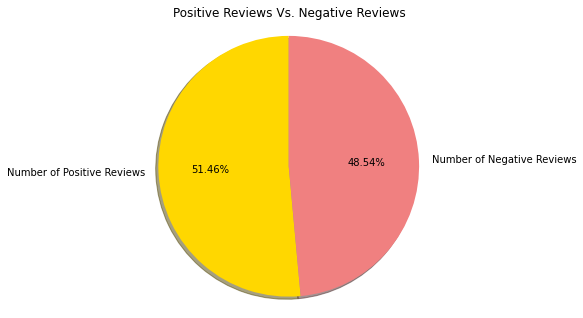

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
values = [len(df_pos_reviews), len(df_neg_reviews)]

ax.pie(values, 
       labels = ['Number of Positive Reviews', 'Number of Negative Reviews'],
       colors=['gold', 'lightcoral'],
       shadow=True,
       startangle=90, 
       autopct='%1.2f%%')
ax.axis('equal')
plt.title('Positive Reviews Vs. Negative Reviews');

###**The Distribution of Ratings**

Creating Histogram of ratings

In [ ]:
# Histogram of Ratings
print(df_reviewers_info['Rating'].describe())
px.histogram(df_reviewers_info, x="Rating", nbins=30, title = 'Histogram of Ratings')

count    1030.000000
mean        7.578544
std         1.801510
min         1.000000
25%         6.700000
50%         7.900000
75%         8.800000
max        10.000000
Name: Rating, dtype: float64


*The histogram rating is left skewed*

In [ ]:
top10_df = df_reviewers_info.groupby('Country').size().reset_index().sort_values(0, ascending = False).head(10)
top10_df.columns = ['Country', 'Counts']


In [ ]:
#Define tag list
tag_list = ['Business','Leisure','Group','Couple','Family','friends','Solo']

#Count for each review tag
tag_counts = []
for tag in tag_list:
    counts = df_reviewers_info['Review_tags'].str.count(tag).sum()
    tag_counts.append(counts)

#Convert to a dataframe
trip_type = pd.DataFrame({'Trip Type':tag_list,'Counts':tag_counts}).sort_values('Counts',ascending = False)

#Visualize the trip type counts from Review_tags
fig = px.bar(trip_type, x='Trip Type', y='Counts', title='Review Tags Counts for each Trip Type')
fig.show()

##**Text Analytics**

Lemmatize Tokens

Lemmatization links words with similar meaning to one word.Used NLTK to lemmatize words.

In [ ]:
# Create a function to define a mapping between wordnet tags and POS tags 
def get_wordnet_pos(pos_tag):

    if pos_tag.startswith('J'):
        return wordnet.ADJ 

    elif pos_tag.startswith('V'):
        return wordnet.VERB 

    elif pos_tag.startswith('N'):
        return wordnet.NOUN

    elif pos_tag.startswith('R'):
        return wordnet.ADV
    
    else:
        return wordnet.NOUN # default, return wordnet tag "NOUN"

#Create a function to lemmatize tokens in the reviews
def lemmatized_tokens(text):
        text = text.lower()
        pattern = r'\b[a-zA-Z]{3,}\b'                 
        tokens = nltk.regexp_tokenize(text, pattern) # tokenize the text
        tagged_tokens = nltk.pos_tag(tokens)  # a list of tuples (word, pos_tag)
          
        stop_words = stopwords.words('english')
        new_stopwords = ["hotel","everything","anything","nothing","thing","need",
                        "good","great","excellent","perfect","much","even","really"]  #customize extra stop_words
        stop_words.extend(new_stopwords)
        stop_words = set(stop_words)
        
        wordnet_lemmatizer = WordNetLemmatizer()
        # get lemmatized tokens                             #call function "get_wordnet_pos"
        lemmatized_words=[wordnet_lemmatizer.lemmatize(word, get_wordnet_pos(tag)) 
                  # tagged_tokens is a list of tuples (word, tag)
                  for (word, tag) in tagged_tokens \
                  # remove stop words
                  if word not in stop_words and \
                  # remove punctuations
                  word not in string.punctuation]

        return lemmatized_words


###**Generate WordClouds**

Defined a function that would run for both positive and negative reviews and plot the wordclouds

In [ ]:
def wordcloud(review_df, review_colname, color, title):
    text = review_df[review_colname].tolist()
    text_str = ' '.join(lemmatized_tokens(' '.join(text))) #call function "lemmatized_tokens"
    wordcloud = WordCloud(collocations = False,
                          background_color = color,
                          width=1600, 
                          height=800, 
                          margin=2,
                          min_font_size=20).generate(text_str)

    plt.figure(figsize = (15, 10))
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis("off")
    plt.figtext(.5,.8,title,fontsize = 20, ha='center')
    
    return plt.show()

In [ ]:
df_pos_reviews.dtypes

Unnamed: 0           int64
positive_reviews    object
dtype: object

Removing the NA values from the reviews

In [ ]:
# df_pos_reviews = df_pos_reviews.notna
df_pos_reviews
df_pos_reviews = df_pos_reviews.dropna()
df_pos_reviews

,Unnamed: 0,positive_reviews
0,0,"Location is great, short walk away Chinatown a..."
1,1,location more than made up for being outdated ...
2,2,Location
3,3,"Location was good in the Union square area, go..."
4,4,Location
...,...,...
646,646,The location and comfortable bed
647,647,Location ok.
648,648,"Location was good, short walk to many sights,..."
649,649,We stayed here twice in one month. Location is...


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


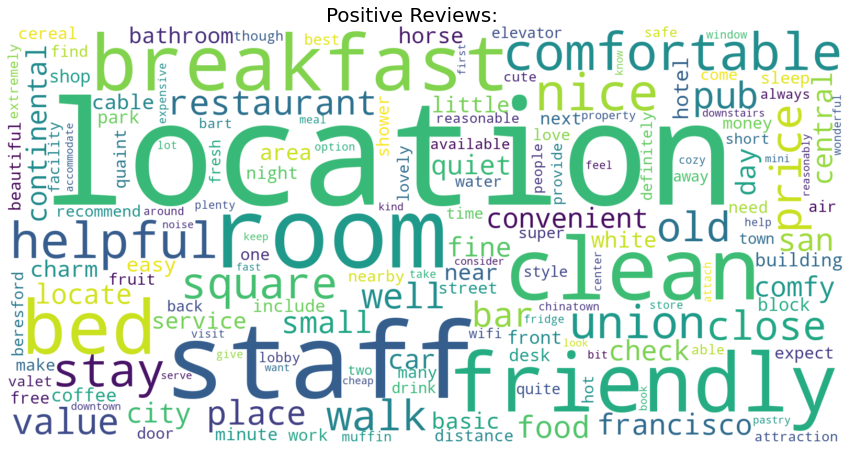

In [ ]:
# Wordcoulds for Positive Reviews
nltk.download('averaged_perceptron_tagger')

nltk.download('stopwords')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('vader_lexicon')
# nltk.download('wordnet')
nltk.download('wordnet')
wordcloud(df_pos_reviews,'positive_reviews', 'white','Positive Reviews:')

###**Positive reviews Result**

From the above plot, we can conclude that most people are probably satisfied with the location, very convenient, comfortable and close to Union Square or Chinatown.

Easy to find restaurants or pubs nearby, friendly and helpful staff

Clean room, comfortable bed, and good price, etc.

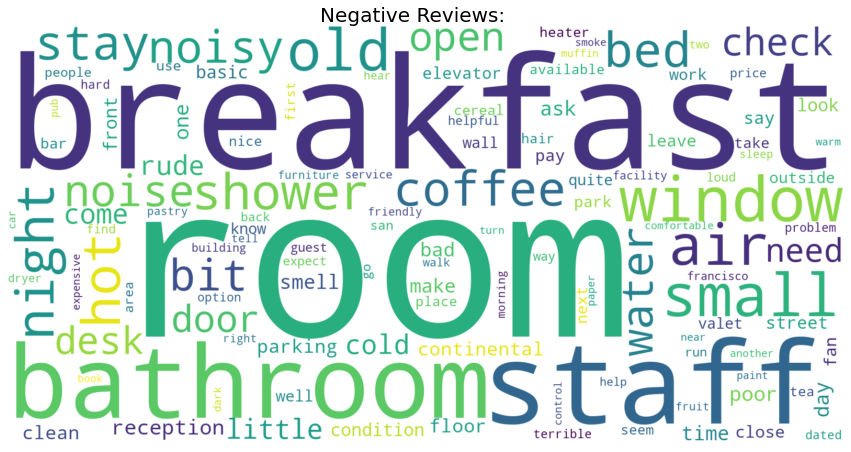

In [ ]:
df_neg_reviews = df_neg_reviews.dropna()
df_neg_reviews
wordcloud(df_neg_reviews,'negative_reviews', 'white','Negative Reviews:')

###**Negative Review Outcome**

Words like “breakfast”, “room” and “staff” are mentioned quite often, which indicates that maybe people were complaining about the staffs who were being rude, small rooms, and coffee/ cereal/ muffin provided during breakfast. 

The air conditioning or the shower system may need improvements as we see words like “hot”, “cold”, “air”, “condition”, “bathroom” and “shower” in the WordCloud.

The hotel may also need to solve issues related to soundproofing and parking.


##**Sentiment Analysis**

**Using the Overall_review column in the df_reviewer_info dataframe to perform the sentiment analysis.**

In [ ]:

#Create a function to get the subjectivity
def subjectivity(text): 
    return TextBlob(text).sentiment.subjectivity

#Create a function to get the polarity
def polarity(text): 
    return TextBlob(text).sentiment.polarity

#Create two new columns
df_reviewers_info['Subjectivity'] = df_reviewers_info['Overall_review'].apply(subjectivity)
df_reviewers_info['Polarity'] = df_reviewers_info['Overall_review'].apply(polarity)

In [ ]:
def getAnalysis(score):
    if score <= -0.6:
      return 'Very Negative'
    elif -0.7 < score <= 0:
      return 'Negative'
    elif score == 0:
      return 'Neutral'
    elif 0.0 < score < 0.6:
      return 'Positive'    
    else:
      return 'Very Positive'

df_reviewers_info['Analysis'] = df_reviewers_info['Polarity'].apply(getAnalysis)

###**Plotting the positive, negative and neutral reviews**

###**Additional Microfactor**

New microfactors have been added that calculates the reviews and tell if the reviews are really bad or really good for the hotel.

Range between -1 to +1 has been considered

Range below -0.6 has been considered as "Very Negative"

Range above 0.6 has been considered as "Very Positive"

In [ ]:
fig = px.scatter(df_reviewers_info, 
                 x='Polarity', 
                 y='Subjectivity', 
                 color = 'Analysis',
                 size='Subjectivity')

#add a vertical line at x=0 for Netural Reviews
fig.update_layout(title='Sentiment Analysis',
                  shapes=[dict(type= 'line',
                               yref= 'paper', y0= 0, y1= 1, 
                               xref= 'x', x0= 0, x1= 0)])
fig.show()

###**Sentimental Analyses Outcome**

The green dots that lies on the vertical line are the “neutral” reviews

The red dots on the left are the “negative” reviews

The blue dots on the right are the “positive” reviews. 

Bigger dots indicate more subjectivity. We see that positive reviews are more than the negatives.

#**Scraping data for new hotel and extracting the reviews info, positive reviews and negative reviews**

In [ ]:
#days-inn-milpitas-milpitas-california
reviewer_info_1, pos_reviews_1, neg_reviews_1 = scrape_reviews('days-inn-milpitas-milpitas-california',total_pages = 40)


,Rating,Name,Country,Overall_review,Review_times,Review_date,Review_tags
0,8.0,Elizabeth,United States of America,Very clean with good housekeeping service. Ni...,7,2021-11-14,"Leisure trip, Solo traveler, Queen Room with M..."
1,7.0,V,Philippines,Good,12,2021-11-09,"Leisure trip, Family with young children, Quee..."
2,7.0,Hernandez,United States of America,good,3,2021-11-04,"Business trip, Family with young children, Del..."
3,8.0,Marhayra,United States of America,Very Good,18,2021-11-01,"Leisure trip, Couple, Deluxe King Room - Non-S..."
4,7.0,Cecilia,United States of America,rude front desk clerk,7,2021-10-22,"Leisure trip, Family with young children, Delu..."
...,...,...,...,...,...,...,...
955,7.0,Vanessa,United States of America,Good,1,2021-08-19,"Leisure trip, Couple, Queen Room with Two Quee..."
956,9.0,Russell,United States of America,Great America,2,2021-08-16,"Leisure trip, Family with young children, Delu..."
957,8.0,Ekaterina,United States of America,Very Good,4,2021-08-06,"Leisure trip, Family with young children, Quee..."
958,8.0,Fe,United States of America,I feel comfortable and relaxed during my stay ...,1,2021-08-02,"Leisure trip, Solo traveler, Deluxe King Room ..."


**Plotting the reviews by differentiating the positive, negative reviews**

In [ ]:
reviewer_info_1['Subjectivity'] = reviewer_info_1['Overall_review'].apply(subjectivity)
reviewer_info_1['Polarity'] = reviewer_info_1['Overall_review'].apply(polarity)
reviewer_info_1['Analysis'] = reviewer_info_1['Polarity'].apply(getAnalysis)
# from scikitplot.metrics import plot_confusion_matrix
# vectorizer = TfidfVectorizer(ngram_range=(1, 2), tokenizer=tokenizer.tokenize)
fig = px.scatter(reviewer_info_1, 
                 x='Polarity', 
                 y='Subjectivity', 
                 color = 'Analysis',
                 size='Subjectivity')

#add a vertical line at x=0 for Netural Reviews
fig.update_layout(title='Sentiment Analysis',
                  shapes=[dict(type= 'line',
                               yref= 'paper', y0= 0, y1= 1, 
                               xref= 'x', x0= 0, x1= 0)])
fig.show()

**Out of two datasets, one dataset has been chosen to train the model. Once the model has been trained, another dataset has been used to test the model by checking the accuracy of the prediction.**

###**GradientBoostingClassifier has been used to train the model**

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
# def text_transformation(df_col):
#     corpus = []
#     for item in df_col:
#         new_item = re.sub('[^a-zA-Z]',' ',str(item))
#         new_item = new_item.lower()
#         new_item = new_item.split()
#         new_item = [lm.lemmatize(word) for word in new_item]
#         corpus.append(' '.join(str(x) for x in new_item))
#     return corpus
# df_reviewers_info


cv = CountVectorizer()
traindata = cv.fit_transform(reviewer_info_1['Overall_review'])
# df_reviewers_info['Overall_review']
rf = GradientBoostingClassifier(random_state=42, n_estimators=100)
# ignore_cols = ["Review_date", "country", "name", "unnamed", "review_tags",'analysis']
# features = [c for c in df_reviewers_info.columns if c not in ignore_cols]
# rf.fit(traindata[:,:61],df_reviewers_info['Analysis'])
rf.fit(traindata,reviewer_info_1['Analysis'])
# df_reviewers_info['Overall_review']
# traindata
traindata

<960x39 sparse matrix of type '<class 'numpy.int64'>'
	with 2800 stored elements in Compressed Sparse Row format>

###**Calculating the accuracy of the model by providing the test dataset**

In [ ]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,classification_report,classification_report
# fig.show()
# testdata
testdata = cv.fit_transform(df_reviewers_info['Overall_review'])
# testdata
# predictions = rf.predict(testdata)
predictions = rf.predict(testdata[:,:39])
# predictions = rf.predict(reviewer_info_1[['Polarity','Subjectivity']])
predictions
# y_test=reviewer_info_1['Analysis']
y_test=df_reviewers_info['Analysis']
# # rcParams['figure.figsize'] = 10,5
# # plot_confusion_matrix(y_test,predictions)
acc_score = accuracy_score(y_test,predictions)
# pre_score = precision_score(y_test,predictions)
# rec_score = recall_score(y_test,predictions)
print('Accuracy_score: ',acc_score)
# print('Precision_score: ',pre_score)
# print('Recall_score: ',rec_score)
print("-"*50)
cr = classification_report(y_test,predictions)
print(cr)

Accuracy_score:  0.6737864077669903
--------------------------------------------------
               precision    recall  f1-score   support

     Negative       0.17      0.10      0.13       126
     Positive       0.31      0.05      0.09       191
Very Negative       0.00      0.00      0.00        21
Very Positive       0.73      0.97      0.83       692

     accuracy                           0.67      1030
    macro avg       0.30      0.28      0.26      1030
 weighted avg       0.57      0.67      0.59      1030



##**RandomForestClassifier**



In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
# def text_transformation(df_col):
#     corpus = []
#     for item in df_col:
#         new_item = re.sub('[^a-zA-Z]',' ',str(item))
#         new_item = new_item.lower()
#         new_item = new_item.split()
#         new_item = [lm.lemmatize(word) for word in new_item]
#         corpus.append(' '.join(str(x) for x in new_item))
#     return corpus
# df_reviewers_info


cv = CountVectorizer()
traindata = cv.fit_transform(reviewer_info_1['Overall_review'])
# df_reviewers_info['Overall_review']
rf = RandomForestClassifier(random_state=42, n_estimators=100)
# ignore_cols = ["Review_date", "country", "name", "unnamed", "review_tags",'analysis']
# features = [c for c in df_reviewers_info.columns if c not in ignore_cols]
# rf.fit(traindata[:,:61],df_reviewers_info['Analysis'])
rf.fit(traindata,reviewer_info_1['Analysis'])
# df_reviewers_info['Overall_review']
# traindata
traindata

<960x39 sparse matrix of type '<class 'numpy.int64'>'
	with 2800 stored elements in Compressed Sparse Row format>

In [ ]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,classification_report,classification_report
# fig.show()
# testdata
testdata = cv.fit_transform(df_reviewers_info['Overall_review'])
# testdata
# predictions = rf.predict(testdata)
predictions = rf.predict(testdata[:,:39])
# predictions = rf.predict(reviewer_info_1[['Polarity','Subjectivity']])
predictions
# y_test=reviewer_info_1['Analysis']
y_test=df_reviewers_info['Analysis']
# # rcParams['figure.figsize'] = 10,5
# # plot_confusion_matrix(y_test,predictions)
acc_score = accuracy_score(y_test,predictions)
# pre_score = precision_score(y_test,predictions)
# rec_score = recall_score(y_test,predictions)
print('Accuracy_score: ',acc_score)
# print('Precision_score: ',pre_score)
# print('Recall_score: ',rec_score)
print("-"*50)
cr = classification_report(y_test,predictions)
print(cr)

Accuracy_score:  0.6718446601941748
--------------------------------------------------
               precision    recall  f1-score   support

     Negative       0.00      0.00      0.00       126
     Positive       0.00      0.00      0.00       191
Very Negative       0.00      0.00      0.00        21
Very Positive       0.67      1.00      0.81       692

     accuracy                           0.67      1030
    macro avg       0.17      0.25      0.20      1030
 weighted avg       0.45      0.67      0.54      1030



###**Found the accuarcy of the model is 67% which is considered good**

In [ ]:
!pip install scikit-plot
from scikitplot.metrics import plot_confusion_matrix

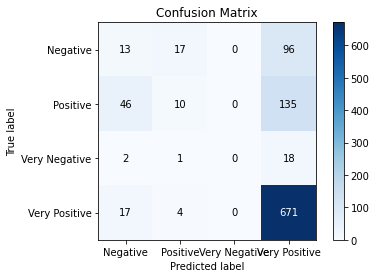

In [ ]:
plot_confusion_matrix(y_test,predictions)

##**LDA Topic Modeling**

Applying LDA model to find each document topic distribution and the high probability of word in each topic. Here, we want to specifically look at the negative reviews to find out what aspects should the hotel be focusing on improving.

Steps to find the optimal LDA model:

1. Convert the reviews to document-term matrix

2. GridSearch and tune for the optimal LDA model

3. Output the optimal lda model and its parameters

4. Compare LDA Model Performance Scores

A line plot to show the LDA model performance scores of with different params

In [ ]:
#Create a function to build the optimal LDA model
def optimal_lda_model(df_review, review_colname):
    docs_raw = df_review[review_colname].tolist()

    #************   Step 1: Convert to document-term matrix   ************#

    #Transform text to vector form using the vectorizer object 
    tf_vectorizer = CountVectorizer(strip_accents = 'unicode',
                                    stop_words = 'english',
                                    lowercase = True,
                                    token_pattern = r'\b[a-zA-Z]{3,}\b', # num chars > 3 to avoid some meaningless words
                                    max_df = 0.9,                        # discard words that appear in > 90% of the reviews
                                    min_df = 10)                         # discard words that appear in < 10 reviews    

    #apply transformation
    tfidf_vectorizer = TfidfVectorizer(**tf_vectorizer.get_params())

    #convert to document-term matrix
    dtm_tfidf = tfidf_vectorizer.fit_transform(docs_raw)  

    print("The shape of the tfidf is {}, meaning that there are {} {} and {} tokens made through the filtering process.".\
              format(dtm_tfidf.shape,dtm_tfidf.shape[0], review_colname, dtm_tfidf.shape[1]))

    
    #*******   Step 2: GridSearch & parameter tuning to find the optimal LDA model   *******#

    # Define Search Param
    search_params = {'n_components': [5, 10, 15, 20, 25, 30], 
                     'learning_decay': [.5, .7, .9]}

    # Init the Model
    lda = LatentDirichletAllocation()

    # Init Grid Search Class
    model = GridSearchCV(lda, param_grid=search_params)

    # Do the Grid Search
    model.fit(dtm_tfidf)


    #*****  Step 3: Output the optimal lda model and its parameters  *****#

    # Best Model
    best_lda_model = model.best_estimator_

    # Model Parameters
    print("Best Model's Params: ", model.best_params_)

    # Log Likelihood Score: Higher the better
    print("Model Log Likelihood Score: ", model.best_score_)

    # Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
    print("Model Perplexity: ", best_lda_model.perplexity(dtm_tfidf))


    #***********   Step 4: Compare LDA Model Performance Scores   ***********#

    #Get Log Likelyhoods from Grid Search Output
    gscore=model.fit(dtm_tfidf).cv_results_
    n_topics = [5, 10, 15, 20, 25, 30]

    log_likelyhoods_5 = [gscore['mean_test_score'][gscore['params'].index(v)] for v in gscore['params'] if v['learning_decay']==0.5]
    log_likelyhoods_7 = [gscore['mean_test_score'][gscore['params'].index(v)] for v in gscore['params'] if v['learning_decay']==0.7]
    log_likelyhoods_9 = [gscore['mean_test_score'][gscore['params'].index(v)] for v in gscore['params'] if v['learning_decay']==0.9]

    # Show graph
    plt.figure(figsize=(12, 8))
    plt.plot(n_topics, log_likelyhoods_5, label='0.5')
    plt.plot(n_topics, log_likelyhoods_7, label='0.7')
    plt.plot(n_topics, log_likelyhoods_9, label='0.9')
    plt.title("Choosing Optimal LDA Model")
    plt.xlabel("Num Topics")
    plt.ylabel("Log Likelyhood Scores")
    plt.legend(title='Learning decay', loc='best')
    plt.show()
    
    return best_lda_model, dtm_tfidf, tfidf_vectorizer

The shape of the tfidf is (609, 138), meaning that there are 609 negative_reviews and 138 tokens made through the filtering process.
Best Model's Params:  {'learning_decay': 0.9, 'n_components': 5}
Model Log Likelihood Score:  -1823.582839011521
Model Perplexity:  299.3828900048782


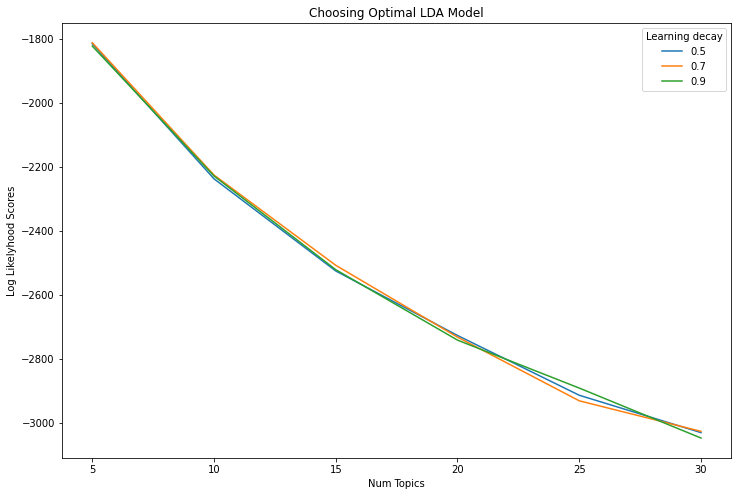

In [ ]:
best_lda_model, dtm_tfidf, tfidf_vectorizer = optimal_lda_model(df_neg_reviews, 'negative_reviews')

From the graph, we see that there is little impact to choose different learning decay.

5 topics would produce the best model.

In [ ]:

#Create a function to inspect the topics we created 
def display_topics(model, feature_names, n_top_words):
    
    topic_dict = {}
    for topic_idx, topic in enumerate(model.components_):
        topic_dict["Topic %d words" % (topic_idx+1)]= ['{}'.format(feature_names[i])
                        for i in topic.argsort()[:-n_top_words - 1:-1]]
        topic_dict["Topic %d weights" % (topic_idx+1)]= ['{:.1f}'.format(topic[i])
                        for i in topic.argsort()[:-n_top_words - 1:-1]]
    return pd.DataFrame(topic_dict)


display_topics(best_lda_model, tfidf_vectorizer.get_feature_names(), n_top_words = 20)

,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights,Topic 3 words,Topic 3 weights,Topic 4 words,Topic 4 weights,Topic 5 words,Topic 5 weights
0,room,26.2,breakfast,58.4,air,19.8,staff,22.2,parking,15.3
1,small,20.0,coffee,13.0,room,19.1,reception,12.7,valet,8.2
2,bathroom,14.8,continental,12.0,window,12.3,poor,12.5,way,7.7
3,need,12.8,basic,11.9,conditioning,12.3,desk,12.3,work,7.3
4,hotel,12.5,good,9.5,noise,12.1,rude,12.0,didn,6.7
5,water,12.1,little,8.2,smell,8.8,really,7.4,expensive,6.4
6,old,12.0,available,7.4,outside,8.8,check,7.1,staff,6.3
7,hot,10.2,variety,7.3,open,8.8,didn,6.8,bad,6.2
8,bit,8.8,limited,6.6,night,8.7,room,6.6,friendly,6.1
9,bed,8.5,conditioner,5.7,loud,8.2,dated,6.5,pastries,6.1


###**Visualize the topics with pyLDAVis Visualization!**

On the left-hand side of the visualization, each topic is represented by a bubble. The larger the bubble, the more prevalent is that topic.

The distance between two bubbles represents the topic similarity.


The right-hand side shows the top-30 most relevant terms for the topic selected on the left. 

The blue bar represents the overall term frequency, and the red bar indicates the estimated term frequency within the selected topic. 

So, if you see a bar with both red and blue, it means the term also appears at other topics. 

###**Interactive Visualization through slider**

In [ ]:
pyLDAvis.sklearn.prepare(best_lda_model, dtm_tfidf, tfidf_vectorizer)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.167764  0.109349       1        1  24.618171
0     -0.116378  0.098594       2        1  22.924706
1      0.255000  0.093599       3        1  18.760668
3     -0.043080 -0.240494       4        1  17.131011
4      0.072223 -0.061049       5        1  16.565443, topic_info=          Term       Freq      Total Category  logprob  loglift
14   breakfast  55.000000  55.000000  Default  30.0000  30.0000
114      staff  27.000000  27.000000  Default  29.0000  29.0000
91     parking  15.000000  15.000000  Default  28.0000  28.0000
0          air  18.000000  18.000000  Default  27.0000  27.0000
102  reception  12.000000  12.000000  Default  26.0000  26.0000
..         ...        ...        ...      ...      ...      ...
54        good   3.667263  12.770214   Topic5  -4.0169   0.5502
22      coffee   3.054313  15.171040   Topic5  -4.1998   0.1950
104       room   4.155900  54.385862   Topic5  -3.8918  -0.7737
66        just   2.868551  12.262934   Topic5  -4.2626   0.3451
14   breakfast   2.695130  55.685856   Topic5  -4.3249  -1.2304

[204 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
0         1  0.934765      air
1         4  0.532005     area
1         5  0.354670     area
2         1  0.485591      ask
2         4  0.485591      ask
...     ...       ...      ...
135       2  0.142367   window
136       1  0.685594  windows
136       4  0.137119  windows
136       5  0.137119  windows
137       5  0.911116     work

[272 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 2, 4, 5])

##**Conclusion**

*   The train dataset used to train the model provides a good prediction for the hotel reviews whether they are positive, negative, very positive or very negative.

*   The accuracy of the prediction is around 70% which is considered good.

*   From the Sentiment Analysis scatter plot, we see that positive reviews are slightly more than the negatives.  
*   Hotel Hilton definitely needs to improve hotel guest satisfaction.

*   The WordCloud reveals some problems for the hotel manager to look into, like their breakfast.

*   The hotel manager should train staff well to provide friendlier and better services.

*   The hotel may also need to work with issues related to soundproofing, air conditioning, shower system and parking.

*   The EDA section could give the hotel manager a general idea of the reviews as well as the rating distribution. 

*   The pyLDAvis interactive visualization would help the hotel manager to further understand what most popular topics within the negative reviews are and make improvements accordingly.








 



 

 



